In [1]:
import timm
import torchvision.transforms as transforms
from torch.onnx.symbolic_opset9 import tensor
from torchvision.models import resnet50
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from transformers import CLIPProcessor, CLIPModel
import torch

MODEL_DIR = "./data/models"


print("Loading CLIP model...")
# Load the CLIP model and processor
clip_model_path = os.path.join(MODEL_DIR, "clip_model")
if os.path.exists(clip_model_path):
    # load the model weights locally
    clip_model = CLIPModel.from_pretrained(clip_model_path)
    clip_processor = CLIPProcessor.from_pretrained(clip_model_path)
    clip_model.eval()
else:
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    # Save the model weights
    clip_model.save_pretrained(clip_model_path)
    clip_processor.save_pretrained(clip_model_path)


print("Loading AVA Predictor model...")
# Load the AVA model
class AVAModel(torch.nn.Module):
    def __init__(self):
        super(AVAModel, self).__init__()
        self.model = resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

ava_model = AVAModel()
# Save the model weights
os.makedirs(MODEL_DIR, exist_ok=True)
ava_model_path = os.path.join(MODEL_DIR, "ava_model.pt")
torch.save(ava_model.state_dict(), ava_model_path)

ava_model.load_state_dict(torch.load(ava_model_path))
ava_model.eval()

# Preprocessing transformations for AVA model
ava_preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("Loading LAION-Aesthetic Predictor model...")
# Load LAION-Aesthetic Predictor model
laion_model_path = os.path.join(MODEL_DIR, "laion_model.pt")

if os.path.exists(laion_model_path):
    laion_model = timm.create_model('vit_giant_patch14_clip_224.laion2b', pretrained=False)
    laion_model.load_state_dict(torch.load(laion_model_path))
else:
    laion_model = timm.create_model('vit_giant_patch14_clip_224.laion2b', pretrained=True)
    torch.save(laion_model.state_dict(), laion_model_path)

laion_model.eval()  # Set to evaluation mode

# Preprocessing transformations for LAION model
laion_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])



Loading CLIP model...
Loading AVA Predictor model...


/Users/rchaks/opt/miniforge3/envs/travel_agent/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rchaks/opt/miniforge3/envs/travel_agent/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading LAION-Aesthetic Predictor model...


In [7]:
import os
import cv2
import torch
import numpy as np
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

#########################
# Existing setup & models
#########################

# Example AVA model (already loaded globally)
# ava_model = AVAModel()
# ava_model.eval()

# Example AVA preprocess (already defined globally)
# ava_preprocess = transforms.Compose([...])

def resize_and_normalize(image, size=(1024, 1024)):
    image = image.resize(size)
    return image

def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

def is_well_exposed(image, brightness_threshold=(50, 200)):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return brightness_threshold[0] < mean_brightness < brightness_threshold[1]

def reduce_noise(image):
    image = cv2.fastNlMeansDenoisingColored(np.array(image), None, 10, 10, 7, 21)
    return Image.fromarray(image)

def adjust_contrast(image, factor=1.5):
    # Convert to numpy array if not already
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    pil_img = Image.fromarray(image)
    enhancer = ImageEnhance.Contrast(pil_img)
    enhanced_img = enhancer.enhance(factor)
    return enhanced_img

#########################
# New batch processing
#########################

def process_images_batch(image_paths, score_threshold=0.7):
    """
    Processes multiple images in a single batch using only the AVA model for aesthetic scoring.
    Also applies quality checks (blur, exposure, noise reduction, contrast).

    Args:
        image_paths (List[str]): Paths to images.
        score_threshold (float): Minimum score required to 'pass'.

    Returns:
        List[Tuple[str, str, float]]: A list of (image_path, status, score).
    """
    valid_images = []
    preprocessed_tensors = []
    paths_for_scoring = []

    # Step 1: Preprocess each image & collect for batch scoring
    for image_path in image_paths:
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            # If any error reading the image, skip it
            continue

        # Basic resizing
        image = resize_and_normalize(image)

        # # Quality checks (blur, exposure)
        # if is_blurry(image):
        #     valid_images.append((image_path, "Blurry", 0.0))
        #     continue
        #
        # if not is_well_exposed(image):
        #     valid_images.append((image_path, "Not well exposed", 0.0))
        #     continue

        # Noise reduction & contrast
        image = reduce_noise(image)
        image = adjust_contrast(image)

        # Transform for AVA model (turn PIL -> Tensor)
        tensor_img = ava_preprocess(image)
        preprocessed_tensors.append(tensor_img)
        paths_for_scoring.append(image_path)

    # If no images passed the quality checks, return empty
    if not preprocessed_tensors:
        return valid_images

    # Step 2: Batch scoring with AVA
    batch = torch.stack(preprocessed_tensors, dim=0)  # shape: (N, C, H, W)
    with torch.no_grad():
        scores = ava_model(batch).squeeze()  # shape: (N,) if no final activation

    # Step 3: Gather results
    # If 'scores' is a single float (N=1), convert to a list for uniform handling
    if scores.dim() == 0:
        scores = scores.unsqueeze(0)

    for img_path, score in zip(paths_for_scoring, scores):
        score_val = score.item()
        status = "Passed" if score_val >= score_threshold else "Failed"
        valid_images.append((img_path, status, score_val))

    return valid_images

In [8]:
# Example usage
image_dir = "data/x"
image_paths = [os.path.join(image_dir, path) for path in os.listdir(image_dir) if path.endswith(('.png', '.jpg', '.jpeg'))]
valid_images = process_images_batch(image_paths)
valid_images

[('data/x/38D6A787-4272-4F01-8B00-F28636B38145_1_105_c 2.jpeg',
  'Failed',
  -0.18576297163963318),
 ('data/x/E37A11A2-D508-42D2-99B8-B9FD0D93FF6A_1_105_c.jpeg',
  'Failed',
  -0.41274112462997437),
 ('data/x/3C28678E-5C3D-472D-8D71-77C14AA9BA8D_1_105_c.jpeg',
  'Failed',
  -0.13833674788475037),
 ('data/x/3B798855-B418-42B0-973D-68E66EA05A5F_4_5005_c.jpeg',
  'Failed',
  -0.2695472538471222),
 ('data/x/F6FE07DA-5C81-4944-BD5D-9F0E61C8343E_1_105_c.jpeg',
  'Failed',
  -0.0656772255897522),
 ('data/x/0C59D9D0-F383-444E-A48F-218F9C4490E7_1_105_c.jpeg',
  'Failed',
  -0.002536982297897339),
 ('data/x/AF64D335-9621-4435-A672-0B63E9C00EC7_1_105_c.jpeg',
  'Failed',
  -0.11065203696489334),
 ('data/x/269817B0-866F-4FC2-8BD7-3DD5AD4FF0C2_1_105_c 2.jpeg',
  'Failed',
  -0.06411929428577423),
 ('data/x/78F1A66A-0DD6-47DD-9441-BA98E140FB75_1_105_c.jpeg',
  'Failed',
  -0.07681314647197723),
 ('data/x/BA72CE63-351B-41F9-AE1E-E34B66FB61FB_1_105_c.jpeg',
  'Failed',
  -0.25885477662086487),
 ('dat

-0.13445693852210586 0.11769535257849809


(array([ 1.,  5.,  6., 10., 10., 10.,  8.,  3.,  1.,  1.]),
 array([-0.41274112, -0.3520719 , -0.29140268, -0.23073346, -0.17006423,
        -0.10939501, -0.04872579,  0.01194343,  0.07261266,  0.13328188,
         0.1939511 ]),
 <BarContainer object of 10 artists>)

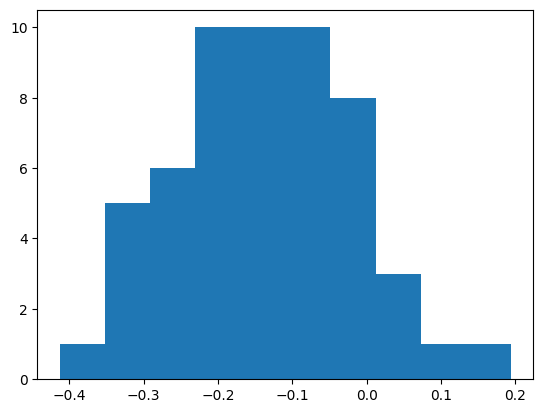

In [9]:
import matplotlib.pyplot as plt
score_array = []
for image_path, message, score in valid_images:
    score_array.append(score)
score_array = np.array(score_array)

print(score_array.mean(), score_array.std())
plt.hist(score_array)

In [12]:
def create_image_canvas(image_paths, title, canvas_size=(1024, 1024), grid_size=(10, 10)):
    canvas = Image.new('RGB', canvas_size, (255, 255, 255))
    img_width, img_height = canvas_size[0] // grid_size[0], canvas_size[1] // grid_size[1]

    for idx, img_path in enumerate(image_paths):
        if idx >= grid_size[0] * grid_size[1]:
            break
        img = Image.open(img_path)
        img = img.resize((img_width, img_height))
        x = (idx % grid_size[0]) * img_width
        y = (idx // grid_size[0]) * img_height
        canvas.paste(img, (x, y))

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(title)
    plt.axis('off')
    plt.show()

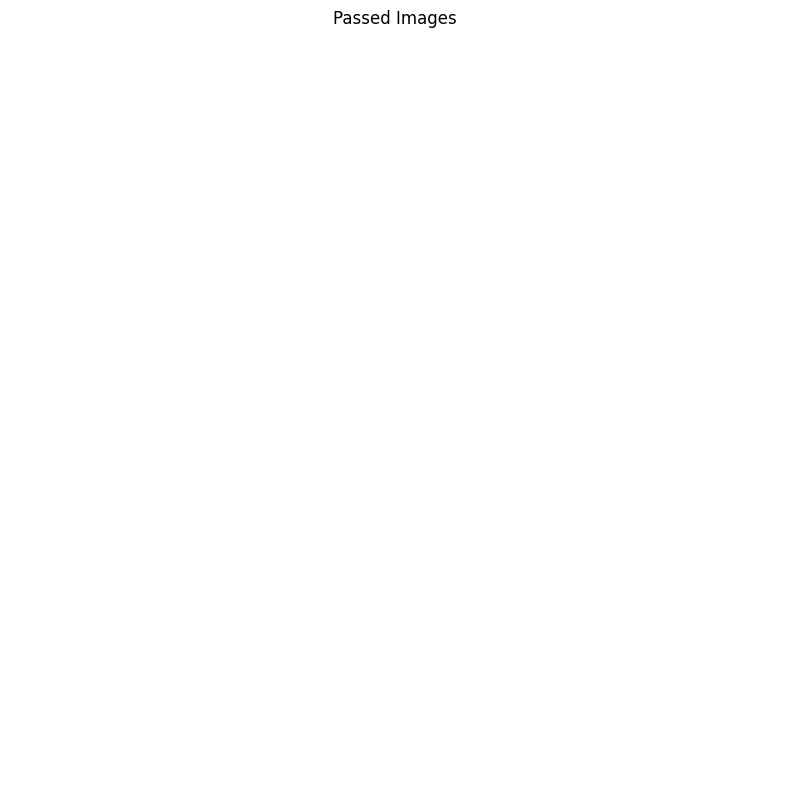

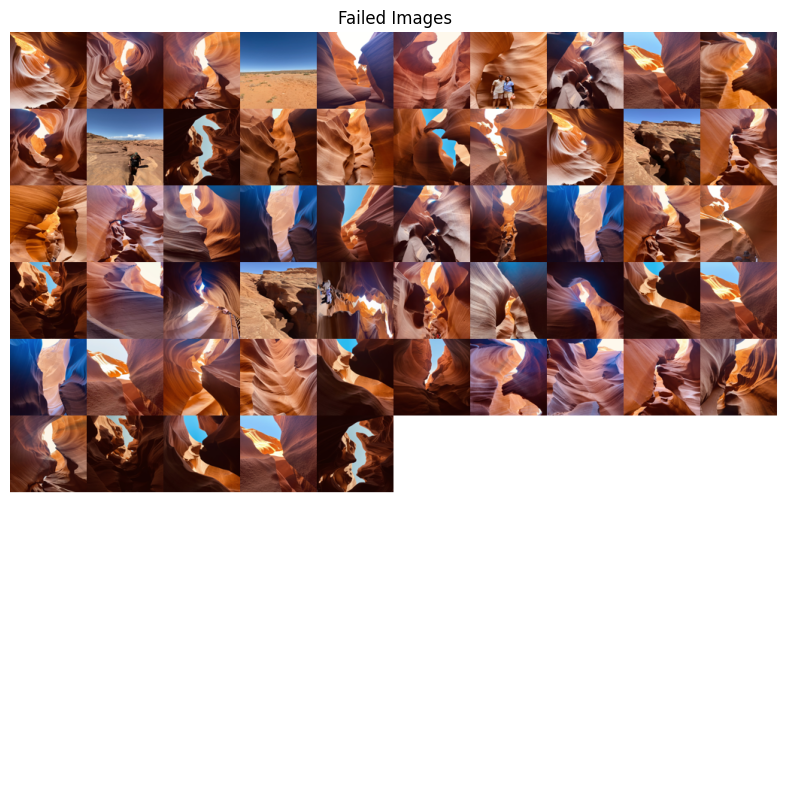

In [13]:
# Separate passed and failed images
passed_images = [img_path for img_path, message, score in valid_images if message == "Passed"]
failed_images = [img_path for img_path, message, score in valid_images if message == "Failed"]

# Create canvases
create_image_canvas(passed_images, "Passed Images")
create_image_canvas(failed_images, "Failed Images")

---

In [10]:

# Function to resize and normalize images
def resize_and_normalize(image, size=(1024, 1024)):
    image = image.resize(size)
    return image

# Function to detect and remove blurry images
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

# Function to check brightness and exposure
def is_well_exposed(image, brightness_threshold=(50, 200)):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return brightness_threshold[0] < mean_brightness < brightness_threshold[1]

# Function to reduce noise
def reduce_noise(image):
    image = cv2.fastNlMeansDenoisingColored(np.array(image), None, 10, 10, 7, 21)
    return Image.fromarray(image)

# Function to adjust contrast
def adjust_contrast(image, factor=1.5):
    image = Image.fromarray(image.squeeze())
    image = image.convert('L')
    enhancer = ImageEnhance.Contrast(image)
    output_image = enhancer.enhance(factor)
    return tensor(output_image.unsqueeze(0))

# Function to predict aesthetics score using AVA model
def predict_aesthetics_ava(image):
    image = ava_preprocess(image).unsqueeze(0)
    with torch.no_grad():
        score = ava_model(image).item()
    return score

def predict_aesthetics_laion(image):
    image = laion_preprocess(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        score = laion_model(image).mean().item()  # Get aesthetic score
    return score



# Function to perform quality checks and aesthetic scoring
def process_images(image_paths, score_threshold=0.21):
    valid_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image = resize_and_normalize(image)

        message = "Passed"

        if is_blurry(image):
            message = "Blurry"
            # visualize_image(image_path, message)
            continue

        if not is_well_exposed(image):
            message = "Not well exposed"
            # visualize_image(image_path, message)
            continue

        image = reduce_noise(image)
        image = adjust_contrast(image)

        score_laion = predict_aesthetics_laion(image)
        score_ava = predict_aesthetics_ava(image)
        score = (score_laion*0.3 + score_ava*0.7)

        if score < score_threshold:
            message = "Failed"
        valid_images.append((image_path, message, score))

    return valid_images

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize((1024, 1024)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = resize_and_normalize(image)
        if self.transform:
            image = self.transform(image).unsqueeze(0)
        return np.array(image), image_path


def process_images_batch(image_paths, score_threshold=0.21, batch_size=32):
    valid_images = []

    # Define the dataset and dataloader
    dataset = ImageDataset(image_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for images, paths in dataloader:
        print(len(images), type(images), len(paths))
        images = [reduce_noise(adjust_contrast(image)) for image in images]

        # Convert images to tensors
        images_tensor = torch.stack([ava_preprocess(image) for image in images])
        laion_images_tensor = torch.stack([laion_preprocess(image) for image in images])

        with torch.no_grad():
            scores_ava = ava_model(images_tensor).squeeze().tolist()
            scores_laion = laion_model(laion_images_tensor).mean(dim=1).tolist()

        for path, score_ava, score_laion in zip(paths, scores_ava, scores_laion):
            score = (score_laion * 0.3 + score_ava * 0.7)
            message = "Passed" if score >= score_threshold else "Failed"
            valid_images.append((path, message, score))

    return valid_images

In [12]:
# Example usage
image_dir = "data/x"
image_paths = [os.path.join(image_dir, path) for path in os.listdir(image_dir) if path.endswith(('.png', '.jpg', '.jpeg'))]
valid_images = process_images_batch(image_paths)

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_56720/3915019119.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(image), image_path


32 <class 'torch.Tensor'> 32


AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [34]:
score_array = []
for image_path, message, score in valid_images:
    score_array.append(score)
score_array = np.array(score_array)


0.189493616000982 0.10427492351261057


(array([ 1.,  1.,  0.,  3.,  5., 11.,  9.,  7.,  3.,  8.]),
 array([-0.11906845, -0.07139458, -0.02372072,  0.02395315,  0.07162701,
         0.11930088,  0.16697475,  0.21464861,  0.26232248,  0.30999634,
         0.35767021]),
 <BarContainer object of 10 artists>)

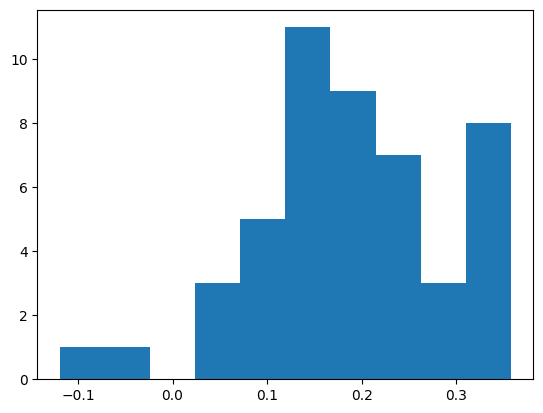

In [35]:
import matplotlib.pyplot as plt
print(score_array.mean(), score_array.std())
plt.hist(score_array)

In [36]:
def create_image_canvas(image_paths, title, canvas_size=(1024, 1024), grid_size=(5, 5)):
    canvas = Image.new('RGB', canvas_size, (255, 255, 255))
    img_width, img_height = canvas_size[0] // grid_size[0], canvas_size[1] // grid_size[1]

    for idx, img_path in enumerate(image_paths):
        if idx >= grid_size[0] * grid_size[1]:
            break
        img = Image.open(img_path)
        img = img.resize((img_width, img_height))
        x = (idx % grid_size[0]) * img_width
        y = (idx // grid_size[0]) * img_height
        canvas.paste(img, (x, y))

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(title)
    plt.axis('off')
    plt.show()

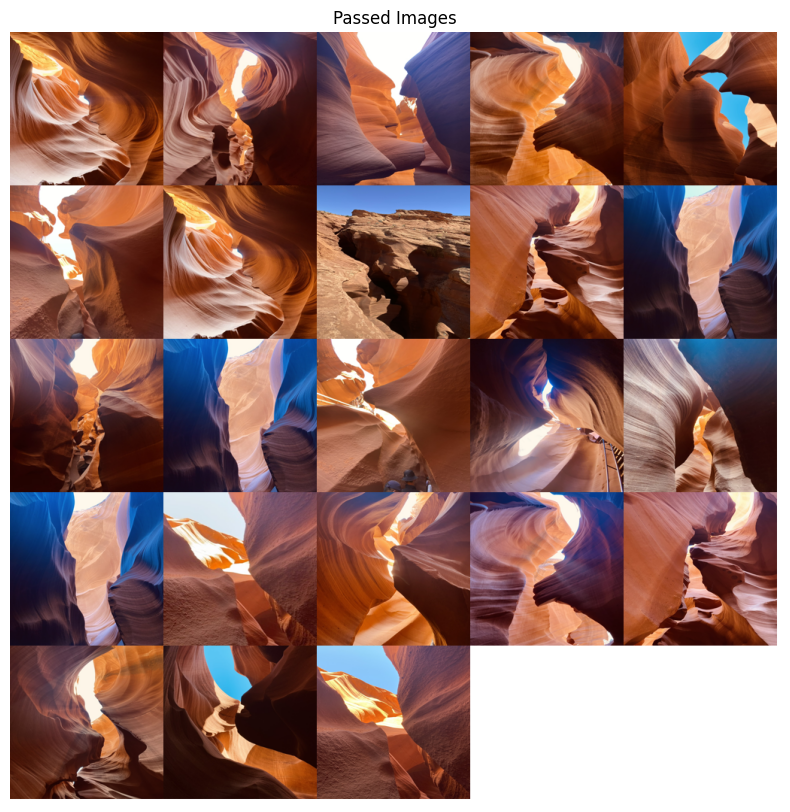

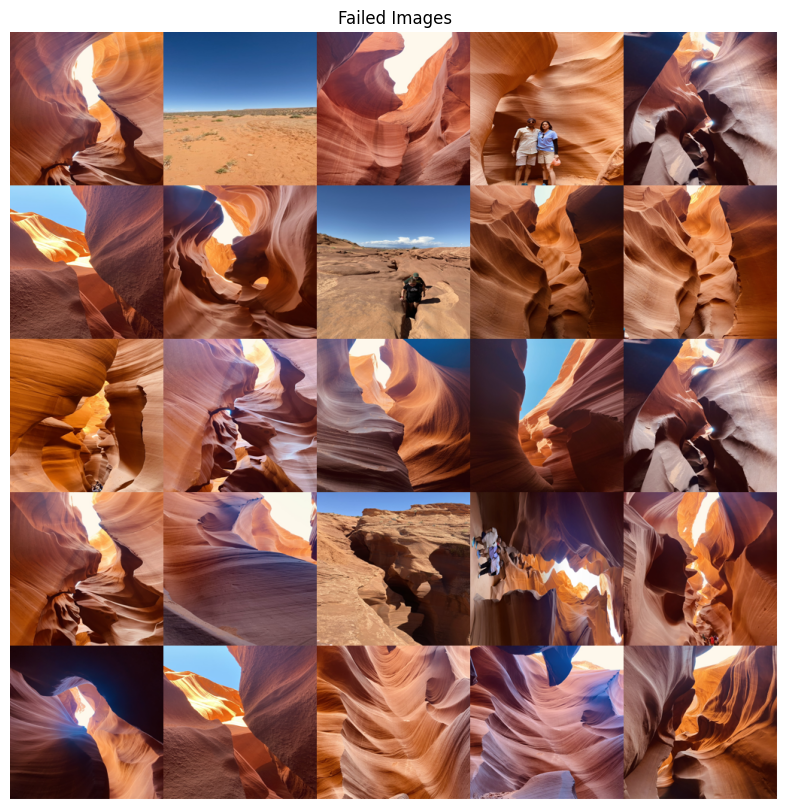

In [37]:
# Separate passed and failed images
passed_images = [img_path for img_path, message, score in valid_images if message == "Passed"]
failed_images = [img_path for img_path, message, score in valid_images if message == "Failed"]

# Create canvases
create_image_canvas(passed_images, "Passed Images")
create_image_canvas(failed_images, "Failed Images")

---